In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 76% 253M/331M [00:00<00:00, 759MB/s] 
100% 331M/331M [00:00<00:00, 735MB/s]


In [4]:
import zipfile
# Unzip the file
zip_file = '/content/utkface-new.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/utkface')

In [5]:
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
print(len(filenames))
print(filenames[:3])

23708
['62_1_0_20170110183746742.jpg.chip.jpg', '21_0_4_20161223214825003.jpg.chip.jpg', '2_1_2_20161219212324493.jpg.chip.jpg']


In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [9]:
#remove outliers
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [10]:
df.head()

,image,age,gender,race
0,26_0_4_20170117195551948.jpg.chip.jpg,26,0,4
1,55_0_0_20170117204213768.jpg.chip.jpg,55,0,0
2,50_0_0_20170117160622711.jpg.chip.jpg,50,0,0
3,67_1_0_20170110143255682.jpg.chip.jpg,67,1,0
4,29_0_1_20170116142845616.jpg.chip.jpg,29,0,1


In [11]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [12]:
df.head()

,image,age,gender,race
0,26_0_4_20170117195551948.jpg.chip.jpg,26,0,4
1,55_0_0_20170117204213768.jpg.chip.jpg,55,0,0
2,50_0_0_20170117160622711.jpg.chip.jpg,50,0,0
3,67_1_0_20170110143255682.jpg.chip.jpg,67,1,0
4,29_0_1_20170116142845616.jpg.chip.jpg,29,0,1


In [13]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [14]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


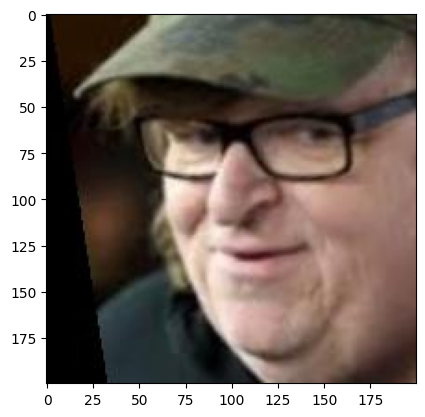

In [15]:
img = Image.open("/content/utkface/UTKFace/"+df['image'][1])
plt.imshow(img)

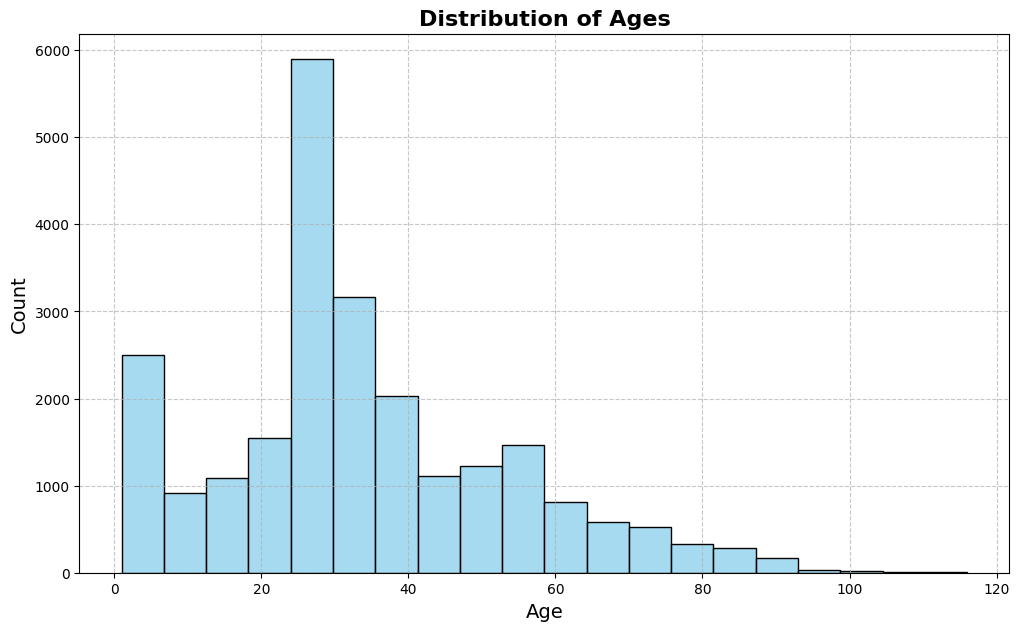

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))


sns.histplot(df['age'], bins=20, kde=False, color='skyblue', edgecolor='black')


plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()

<ipython-input-17-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

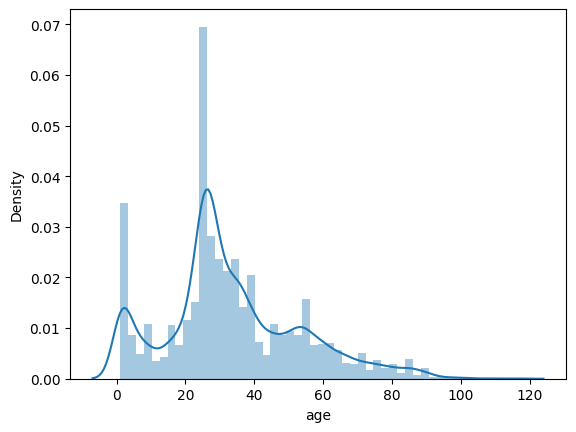

In [17]:
sns.distplot(df.age)

In [18]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [20]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [21]:
train.shape
test.shape
train.head()

,image,age,gender,race
21099,39_0_0_20170104202328306.jpg.chip.jpg,39,0,0
20882,26_1_2_20170116163558042.jpg.chip.jpg,26,1,2
21549,35_0_3_20170117181837205.jpg.chip.jpg,35,0,3
13631,1_1_2_20161219205649948.jpg.chip.jpg,1,1,2
8227,8_1_0_20170109202802966.jpg.chip.jpg,8,1,0


In [22]:
x_train = []
for file in train.image:
    img = load_img("/content/utkface/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [23]:
x_train.shape

(18964, 224, 224, 3)

In [24]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [25]:
from tensorflow.keras.utils import to_categorical

y_race = to_categorical(y_race, num_classes=5)

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform

In [27]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply the VGG16 base model
X = conv_base(inputs)

# Flatten the output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
y_race

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    'best_model_by_race_output.keras',  # Path where the best model will be saved
    monitor='val_race_output_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the metric: 'min' for loss
    verbose=1  # Verbosity level
)

# Train the model with the checkpoint callback
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,  # Set the number of epochs as needed
    batch_size=32,  # Set the batch size as needed
    validation_split=0.1,  # Use a validation split or provide validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - age_output_loss: 3533.6831 - age_output_mean_absolute_error: 37.3996 - gender_output_accuracy: 0.8075 - gender_output_loss: 3.3392 - loss: 3542.2200 - race_output_accuracy: 0.4154 - race_output_loss: 5.1953
Epoch 1: val_race_output_loss improved from inf to 1.35113, saving model to best_model_by_race_output.keras
534/534 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - age_output_loss: 3530.5142 - age_output_mean_absolute_error: 37.3930 - gender_output_accuracy: 0.8076 - gender_output_loss: 3.3348 - loss: 3539.0425 - race_output_accuracy: 0.4154 - race_output_loss: 5.1898 - val_age_output_loss: 1540.0708 - val_age_output_mean_absolute_error: 33.5883 - val_gender_output_accuracy: 0.8751 - val_gender_output_loss: 0.2907 - val_loss: 1540.5138 - val_race_output_accuracy: 0.4302 - val_race_output_loss: 1.3511
Epoch 2/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - age_output_loss: 1479.8293 - age_output_mean_absolute_error: 32.9089 - gender_outp

In [ ]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [ ]:
import numpy

In [ ]:
print(np.argmax(y_race[index]))

1


Original: Gender =  Female  Age =  39  Race =  Indian
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Gender =  Female  Age =  10  Race =  Black


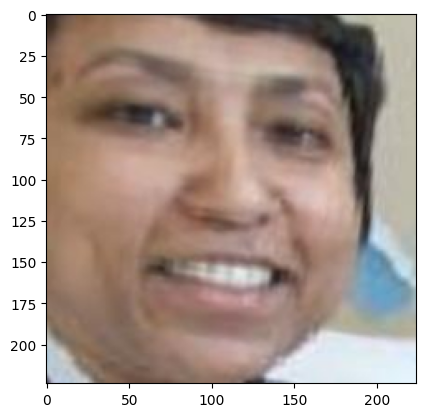

In [ ]:
index=100
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index]," Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender," Age = ", pred_age," Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))

In [ ]:
test.head()

,image,age,gender,race
17817,23_1_2_20170116172852744.jpg.chip.jpg,23,1,2
15083,25_0_3_20170119153018897.jpg.chip.jpg,25,0,3
22832,40_0_4_20170117013731866.jpg.chip.jpg,40,0,4
16077,24_0_2_20170116162912973.jpg.chip.jpg,24,0,2
8974,3_0_0_20170110212707387.jpg.chip.jpg,3,0,0


In [ ]:
#converting Image to numpy array (extracting feature)
x_test = []
for file in test.image:
    img = load_img("/content/utkface/UTKFace/" + file)

    # Resize the image using the correct resampling method
    img = img.resize((224, 224), Image.LANCZOS)

    # Convert the image to a NumPy array
    img = np.array(img)
    x_test.append(img)

# Convert the list of images to a NumPy array
x_test = np.array(x_test)

In [ ]:
#converting labels
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [ ]:
test_acc = model.evaluate(x_test, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)

In [ ]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])

total loss: 935.0440063476562
gender loss: 0.48439306020736694
age loss: 929.0785522460938
race loss: 1.3046740293502808


In [ ]:
x_test.shape
pred = model.predict(x_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step


In [ ]:
pred[2][0]

array([0.46481612, 0.00458151, 0.3416055 , 0.06187426, 0.12712263],
      dtype=float32)

In [ ]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [ ]:
#pred to df
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [ ]:
df_pred['gender'].value_counts()

,count
gender,
Male,2417
Female,2324


In [ ]:
df_pred['age'].value_counts()

,count
age,
10,4741


In [ ]:
df_pred['race'].value_counts()

,count
race,
Black,2323
White,2270
Asian,89
Indian,59


In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

uploaded = files.upload('/content/IMGs.jpg')  # Choose your image from your PC

# Load and preprocess the image
for filename in uploaded.keys():
    img = load_img(filename, target_size=(224, 224))  # resize to match model input
    img_array = img_to_array(img) / 255.0  # normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # reshape for prediction
# Predict
    pred = model.predict(img_array)
    pred_gender = gender_dict[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])
    pred_race = race_dict[round(np.argmax(pred[2][0]))]

    # Print and display
    print("Prediction: Gender =", pred_gender, "Age =", pred_age, "Race =", pred_race)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

KeyboardInterrupt: 